In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(42)
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import save_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [51]:
skin_df = pd.read_csv("HAM10000_metadata.csv")

In [52]:
skin_df.shape

(10015, 7)

In [53]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [54]:
SIZE=32

In [55]:
#label encoding to numeric values from text

le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [56]:
skin_df['label'] = le.transform(skin_df["dx"]) 
skin_df.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
1617,HAM_0007180,ISIC_0033272,mel,histo,65.0,male,face,4
8128,HAM_0007195,ISIC_0031923,nv,histo,40.0,female,lower extremity,5
2168,HAM_0001835,ISIC_0026652,mel,histo,65.0,male,back,4
1090,HAM_0000465,ISIC_0030583,bkl,consensus,35.0,female,trunk,2
7754,HAM_0001720,ISIC_0034010,nv,histo,45.0,male,abdomen,5
8071,HAM_0006333,ISIC_0024424,nv,histo,35.0,male,trunk,5
7423,HAM_0004548,ISIC_0032832,nv,histo,45.0,female,upper extremity,5
8984,HAM_0006526,ISIC_0026671,nv,histo,55.0,male,lower extremity,5
2310,HAM_0003102,ISIC_0032389,mel,histo,65.0,male,face,4
7256,HAM_0004260,ISIC_0025525,nv,histo,65.0,male,back,5


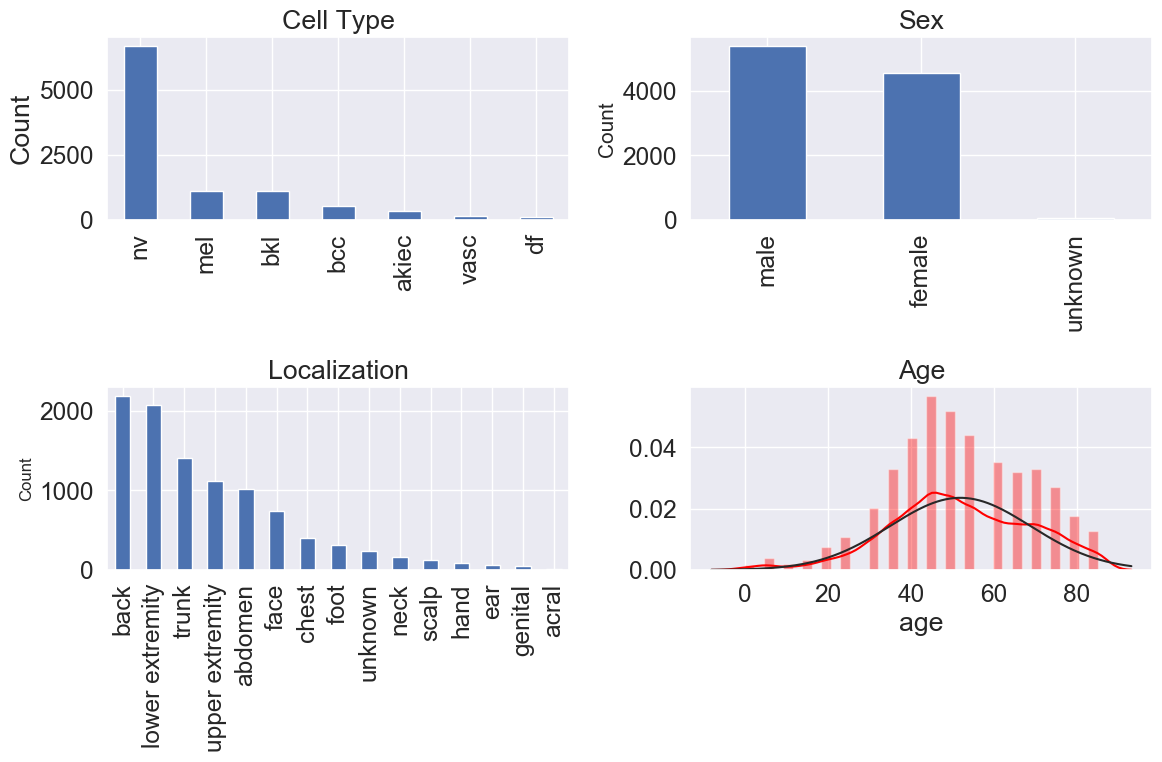

In [57]:
#Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [58]:
#Distribution of data into various classes 

print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [59]:
#Balance data.
#Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [60]:
#Check the distribution. All classes should be balanced now

print(skin_df_balanced['label'].value_counts())

5    500
3    500
1    500
6    500
4    500
2    500
0    500
Name: label, dtype: int64


In [61]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID

image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('*', '*.jpg'))}

In [62]:
image_path

{'ISIC_0024306': 'HAM10000_images_part_1\\ISIC_0024306.jpg',
 'ISIC_0024307': 'HAM10000_images_part_1\\ISIC_0024307.jpg',
 'ISIC_0024308': 'HAM10000_images_part_1\\ISIC_0024308.jpg',
 'ISIC_0024309': 'HAM10000_images_part_1\\ISIC_0024309.jpg',
 'ISIC_0024310': 'HAM10000_images_part_1\\ISIC_0024310.jpg',
 'ISIC_0024311': 'HAM10000_images_part_1\\ISIC_0024311.jpg',
 'ISIC_0024312': 'HAM10000_images_part_1\\ISIC_0024312.jpg',
 'ISIC_0024313': 'HAM10000_images_part_1\\ISIC_0024313.jpg',
 'ISIC_0024314': 'HAM10000_images_part_1\\ISIC_0024314.jpg',
 'ISIC_0024315': 'HAM10000_images_part_1\\ISIC_0024315.jpg',
 'ISIC_0024316': 'HAM10000_images_part_1\\ISIC_0024316.jpg',
 'ISIC_0024317': 'HAM10000_images_part_1\\ISIC_0024317.jpg',
 'ISIC_0024318': 'HAM10000_images_part_1\\ISIC_0024318.jpg',
 'ISIC_0024319': 'HAM10000_images_part_1\\ISIC_0024319.jpg',
 'ISIC_0024320': 'HAM10000_images_part_1\\ISIC_0024320.jpg',
 'ISIC_0024321': 'HAM10000_images_part_1\\ISIC_0024321.jpg',
 'ISIC_0024322': 'HAM100

In [63]:
#Define the path and add it as a new column

skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

#Use the path to read images.

skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [64]:
skin_df_balanced.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path,image
2379,HAM_0001852,ISIC_0033749,vasc,histo,80.0,male,lower extremity,6,HAM10000_images_part_2\ISIC_0033749.jpg,"[[[135, 114, 124], [162, 141, 150], [177, 155,..."
9919,HAM_0006442,ISIC_0033000,akiec,histo,70.0,male,hand,0,HAM10000_images_part_2\ISIC_0033000.jpg,"[[[174, 145, 156], [175, 146, 156], [178, 152,..."
2347,HAM_0007614,ISIC_0027672,vasc,histo,55.0,female,face,6,HAM10000_images_part_1\ISIC_0027672.jpg,"[[[219, 192, 212], [219, 193, 213], [219, 196,..."
2387,HAM_0004820,ISIC_0030722,vasc,consensus,45.0,female,abdomen,6,HAM10000_images_part_2\ISIC_0030722.jpg,"[[[241, 215, 226], [241, 214, 224], [238, 212,..."
1153,HAM_0007418,ISIC_0026313,df,consensus,50.0,male,lower extremity,3,HAM10000_images_part_1\ISIC_0026313.jpg,"[[[151, 105, 102], [166, 123, 123], [177, 139,..."


In [65]:
skin_df_balanced.shape

(3500, 10)

In [66]:
skin_df_balanced['path']

9789    HAM10000_images_part_1\ISIC_0026645.jpg
9957    HAM10000_images_part_1\ISIC_0025780.jpg
9793    HAM10000_images_part_1\ISIC_0024450.jpg
9758    HAM10000_images_part_1\ISIC_0027896.jpg
9875    HAM10000_images_part_1\ISIC_0029268.jpg
                         ...                   
2375    HAM10000_images_part_2\ISIC_0033123.jpg
2436    HAM10000_images_part_1\ISIC_0027790.jpg
2453    HAM10000_images_part_1\ISIC_0024706.jpg
2377    HAM10000_images_part_2\ISIC_0033762.jpg
2363    HAM10000_images_part_2\ISIC_0033031.jpg
Name: path, Length: 3500, dtype: object

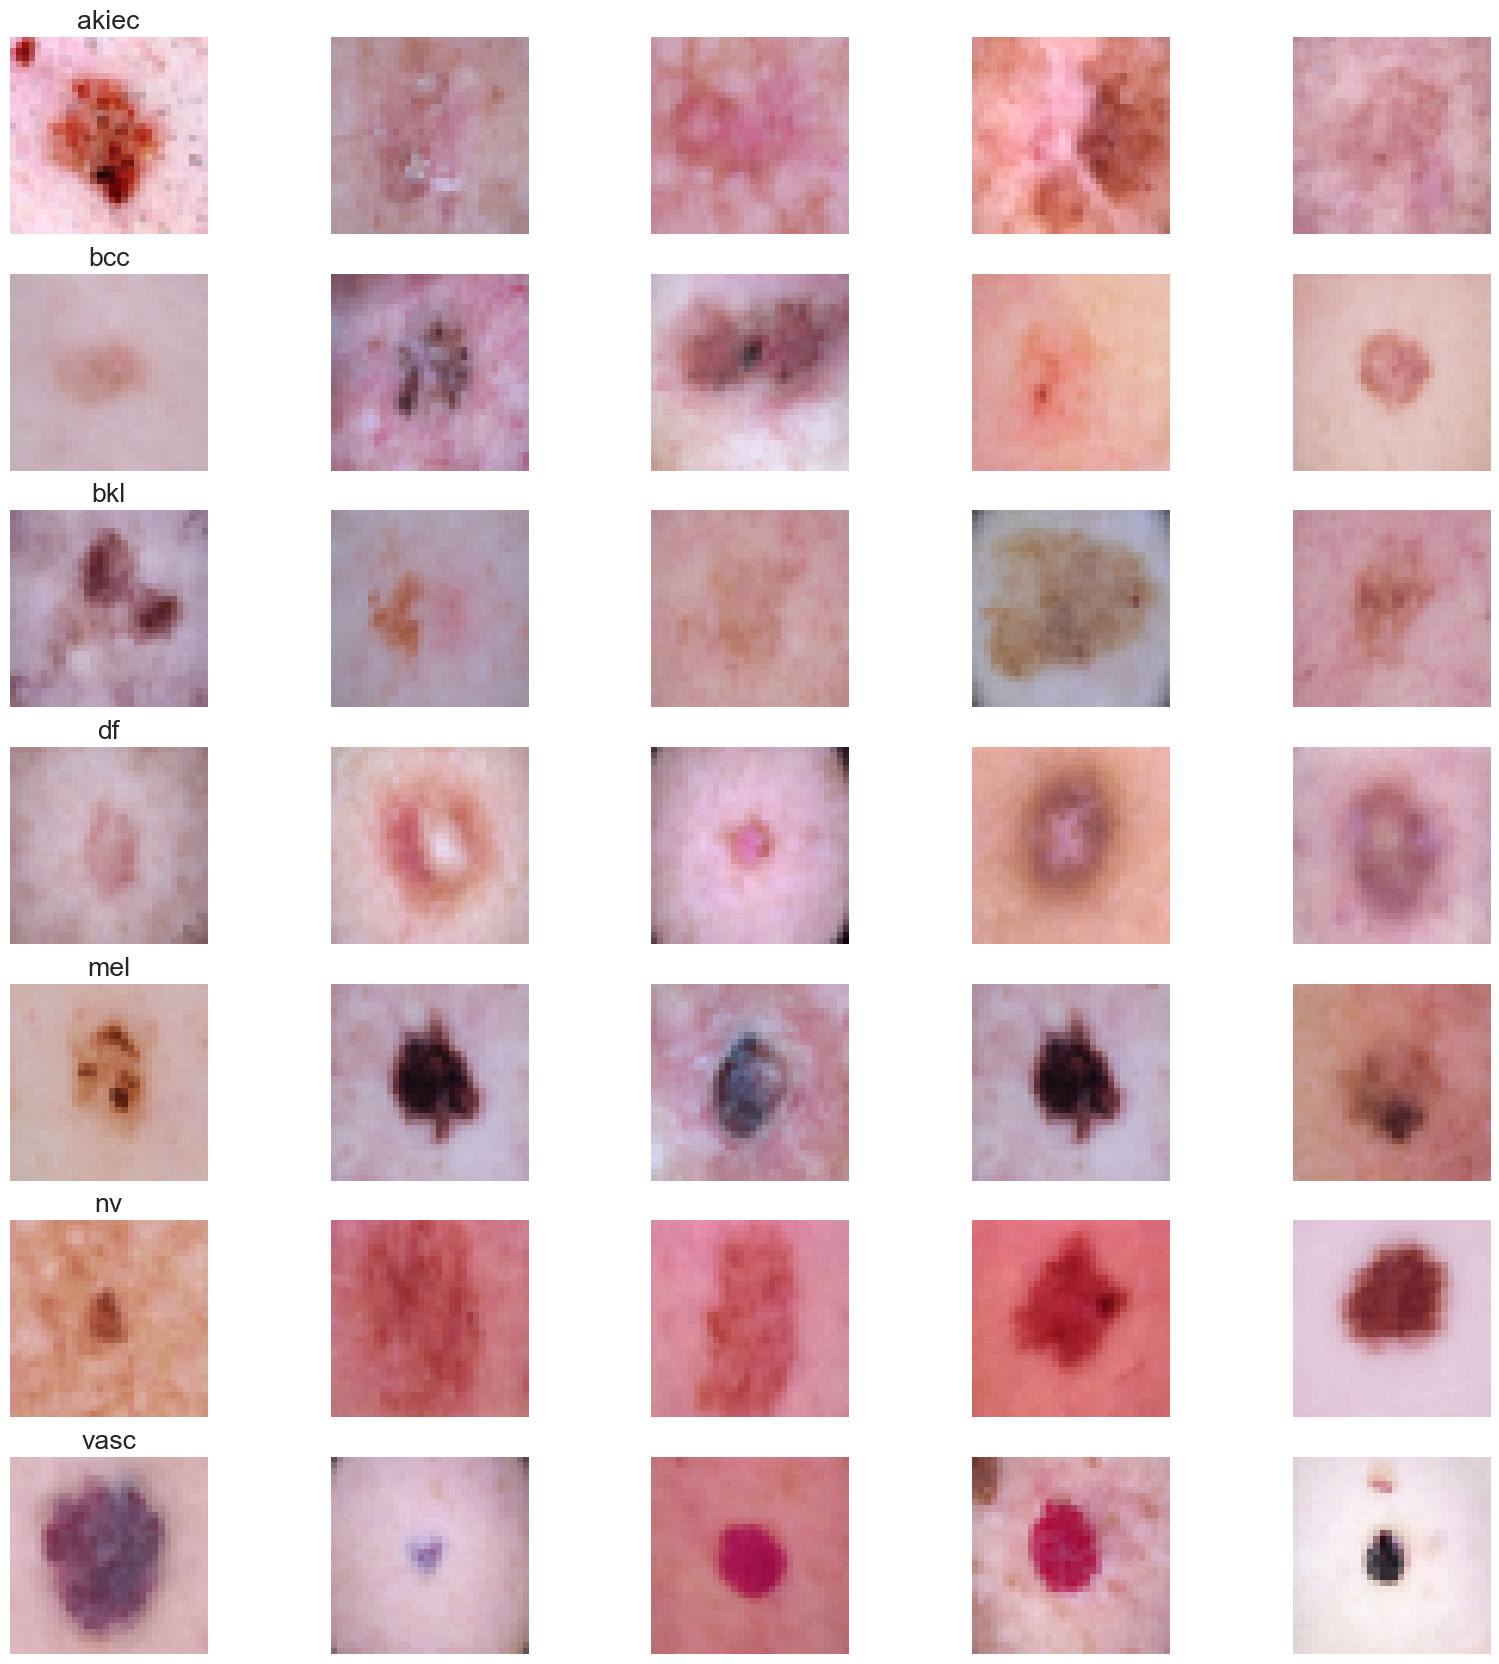

In [67]:
n_samples = 5  # number of samples for plotting

fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [68]:
#Convert dataframe column of images into numpy array

X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y = skin_df_balanced['label']  # Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) # Convert to categorical as this is a multiclass classification problem

In [69]:
#Split to training and testing

x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [70]:
print('Train data:')
print('Shape of x_train: {}'.format(x_train.shape))
print('Shape of y_train: {}'.format(y_train.shape))
print('-----------------------------------------------')
print('Test data:')
print('Shape of x_test: {}'.format(x_test.shape))
print('Shape of y_test: {}'.format(y_test.shape))

Train data:
Shape of x_train: (2625, 32, 32, 3)
Shape of y_train: (2625, 7)
-----------------------------------------------
Test data:
Shape of x_test: (875, 32, 32, 3)
Shape of y_test: (875, 7)


In [71]:
#Define the model.
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16

num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 256)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 128)       295040    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)         

In [72]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [73]:
#Train

batch_size = 16 
epochs = 100

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Train on 2625 samples, validate on 875 samples
Epoch 1/100
2625/2625 - 3s - loss: 1.8976 - acc: 0.2038 - val_loss: 1.7823 - val_acc: 0.2651
Epoch 2/100
2625/2625 - 2s - loss: 1.7004 - acc: 0.2949 - val_loss: 1.6119 - val_acc: 0.3646
Epoch 3/100
2625/2625 - 2s - loss: 1.5127 - acc: 0.3855 - val_loss: 1.4815 - val_acc: 0.3897
Epoch 4/100
2625/2625 - 2s - loss: 1.4297 - acc: 0.4122 - val_loss: 1.4136 - val_acc: 0.4046
Epoch 5/100
2625/2625 - 2s - loss: 1.3753 - acc: 0.4651 - val_loss: 1.3259 - val_acc: 0.4400
Epoch 6/100
2625/2625 - 2s - loss: 1.3383 - acc: 0.4709 - val_loss: 1.4667 - val_acc: 0.4171
Epoch 7/100
2625/2625 - 2s - loss: 1.3150 - acc: 0.4770 - val_loss: 1.3013 - val_acc: 0.4709
Epoch 8/100
2625/2625 - 2s - loss: 1.2742 - acc: 0.5025 - val_loss: 1.2476 - val_acc: 0.4937
Epoch 9/100
2625/2625 - 2s - loss: 1.2604 - acc: 0.5013 - val_loss: 1.2337 - val_acc: 0.5006
Epoch 10/100
2625/2625 - 2s - loss: 1.2121 - acc: 0.5189 - val_loss: 1.2133 - val_acc: 0.4823
Epoch 11/100
2625/2625

Epoch 88/100
2625/2625 - 2s - loss: 0.4989 - acc: 0.8145 - val_loss: 0.7193 - val_acc: 0.7646
Epoch 89/100
2625/2625 - 2s - loss: 0.6570 - acc: 0.7585 - val_loss: 0.7286 - val_acc: 0.7543
Epoch 90/100
2625/2625 - 2s - loss: 0.5258 - acc: 0.7962 - val_loss: 0.7887 - val_acc: 0.7577
Epoch 91/100
2625/2625 - 2s - loss: 0.5041 - acc: 0.8183 - val_loss: 0.7920 - val_acc: 0.7486
Epoch 92/100
2625/2625 - 2s - loss: 0.4900 - acc: 0.8183 - val_loss: 0.7285 - val_acc: 0.7657
Epoch 93/100
2625/2625 - 2s - loss: 0.5509 - acc: 0.8019 - val_loss: 0.7441 - val_acc: 0.7589
Epoch 94/100
2625/2625 - 2s - loss: 0.5154 - acc: 0.8080 - val_loss: 0.8835 - val_acc: 0.7349
Epoch 95/100
2625/2625 - 2s - loss: 0.5356 - acc: 0.8030 - val_loss: 0.7423 - val_acc: 0.7806
Epoch 96/100
2625/2625 - 2s - loss: 0.4510 - acc: 0.8392 - val_loss: 0.7761 - val_acc: 0.7589
Epoch 97/100
2625/2625 - 2s - loss: 0.4795 - acc: 0.8210 - val_loss: 0.8070 - val_acc: 0.7371
Epoch 98/100
2625/2625 - 2s - loss: 0.5026 - acc: 0.8141 - v

In [74]:
score = model.evaluate(x_test, y_test)

875/875 [==============================] - 0s 238us/sample - loss: 0.7899 - acc: 0.7600


In [75]:
score

[0.7898895453044347, 0.76]

In [76]:
type(score)

list

In [77]:
print('Test accuracy: {}%'.format(np.round(score[1]*100, 2)))

Test accuracy: 76.0%


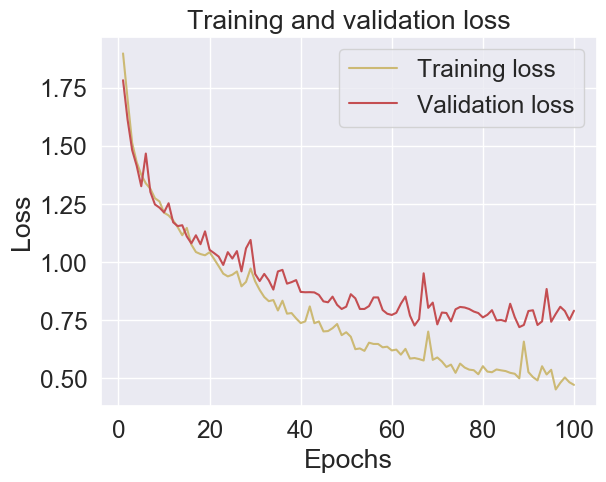

In [78]:
#plot the training and validation accuracy and loss at each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

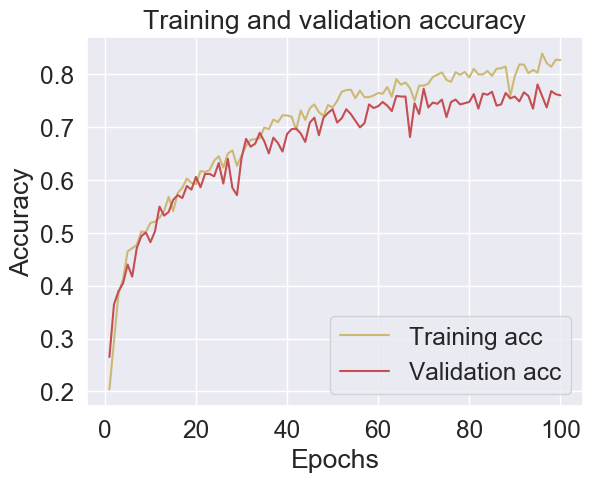

In [79]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [80]:
#Prediction on test data

y_pred = model.predict(x_test)

In [81]:
#Convert predictions classes to one hot vectors

y_pred_classes = np.argmax(y_pred, axis=1)

In [82]:
#Convert test data to one hot vectors

y_true = np.argmax(y_test, axis=1)

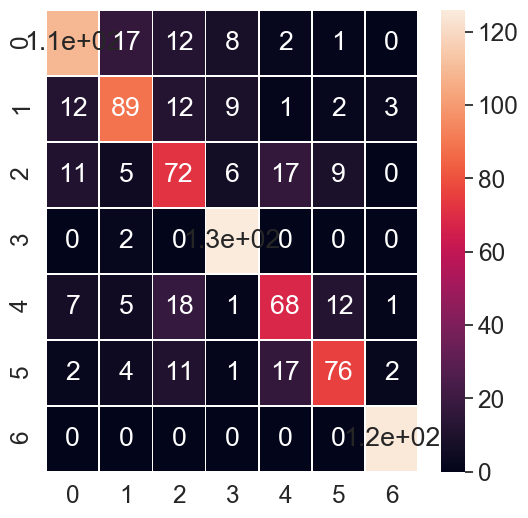

In [83]:
#Print confusion matrix

cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)
plt.show()

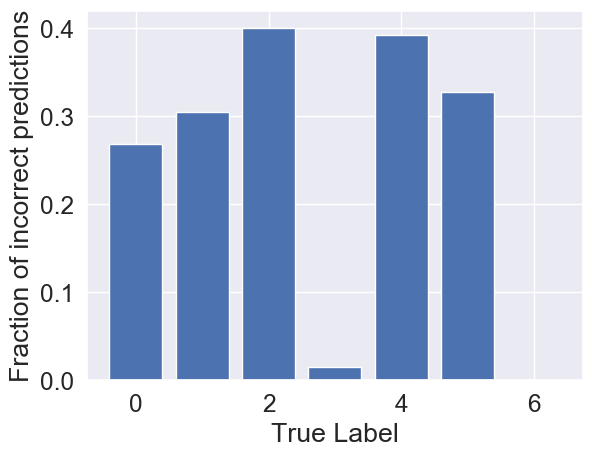

In [84]:
#PLot fractional incorrect misclassifications

incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.show()

In [86]:
#Save the model to a .h5 file

model.save('HAM10000_100epochs.h5')